# **IEG 313 COURSE PROJECT**
## **BY TEAM QUANTZZZ**

### **MEMBERS:**

**`SACHIN SINGH` - `2023BCS0064`**

**`TANISH BABU` - `2023BCS0067`**

**`CHINMOY DAS` - `2023BCS0052`**

**`SHARMA RAGHAV SANDEEP` - `2023BCS0050`**

# **TOPIC : QUANTUM BASED TRAFFIC LIGHT SYSTEM**

# Installation of Required Libraries

### In this step, we install the latest version of Qiskit and its Aer simulator,
### which allows us to simulate quantum circuits locally. Qiskit is the quantum
### computing framework used to build, run, and visualize the Quantum Traffic Light System.


In [1]:
!pip install -q qiskit qiskit-aer
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=4634e716bc14b70311e5e042d6520ce709d29832c8756161aaa68381a57d65f8
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


## **Importing Required Libraries**

In this block, we import all the essential Python libraries needed to build and simulate the Quantum Traffic Light System.

- **math, json, random**: Standard utility libraries for numerical operations, data formatting, and random sampling.
- **NumPy**: Used for numerical computations, especially when handling probability distributions.
- **Matplotlib**: Used to visualize traffic signal durations and probability outcomes through plots.
- **Qiskit & AerSimulator**: These are the core quantum computing components used to build and simulate quantum circuits that determine traffic signal states.
- `np.set_printoptions()` ensures clean numerical output formatting.
- A random number generator (`RNG`) is initialized to keep results reproducible across multiple runs.


In [2]:
import math, json, random      # Standard utilities for mathematical operations, data handling, and randomness
import numpy as np             # Numerical computing library used for probability and vector operations
import matplotlib.pyplot as plt # Plotting library for visualizing results

from qiskit import QuantumCircuit       # Used to construct quantum circuits
from qiskit_aer import AerSimulator     # Quantum circuit simulator (backend execution engine)
np.set_printoptions(precision=4, suppress=True)  # Format numerical outputs clearly (no scientific notation clutter)

RNG = np.random.default_rng(42)  # Reproducible random number generator (ensures consistent simulation results)

## **Road-State Encoding and System Configuration**

In this block, we define how the quantum measurement outcomes correspond to traffic signal decisions.

- The 2-qubit quantum system produces four possible measurement states (`00`, `01`, `10`, `11`).
- We map three of these states to real roads:
  - `|00⟩` → Road A
  - `|01⟩` → Road B
  - `|10⟩` → Road C
- The state `|11⟩` is reserved as a **RESET / All-Red Safety State**, representing a temporary stop for all roads (e.g., emergency clearance).

We then create a **configuration class** (`QTLConfig`) that holds all system parameters such as:
- Base green signal time,
- Scaling factor that increases time based on traffic probability,
- Probability threshold that triggers the all-red reset,
- Temperature to control randomness during decision-making,
- Persistence to prevent rapid switching between roads,
- Optional entanglement strength to model correlated road congestion.


In [3]:
# Mapping of quantum measurement outcomes to corresponding road signals
STATE_TO_ROAD = {'00':'A','01':'B','10':'C','11':'RESET'}

# List of actual active roads (RESET state excluded from duration decisions)
ROADS = ['A','B','C']

# System configuration class holding adjustable parameters for traffic behavior
class QTLConfig:
    base_time = 5.0                 # Minimum green signal time for any road (seconds)
    scale_time = 12.0               # Additional green time proportional to road probability (adaptive factor)
    reset_all_red_secs = 2.0        # Duration of all-red safety interval when RESET state activates
    reset_prob_threshold = 0.10     # If RESET state probability exceeds this value → trigger safety reset
    temperature = 0.9               # Softmax temperature controlling randomness (lower = more deterministic)
    persistence = 0.12              # Encourages staying with previous winning road to avoid rapid switching
    entangle_strength = 0.0         # Controls degree of correlation between roads (0 = no entanglement)

## **Converting Quantum Measurement Results to Traffic Signal Timings**

Once the quantum circuit is executed, it produces measurement counts that indicate how frequently each quantum state occurred. These counts represent the **likelihood** of each road needing priority.

This block performs two key functions:

1. **`counts_to_probs()`**  
   Converts raw measurement counts into normalized probabilities.

2. **`probs_to_durations()`**  
   Translates those probabilities into actual green-light durations:
   \[
   \text{Duration} = \text{Base Time} + (\text{Scale Factor} \times \text{Probability})
   \]
   - Roads with higher measured probability receive **longer green time**.
   - The special `RESET` state is excluded and does not receive a duration.


In [4]:
def counts_to_probs(counts):
    # Convert measurement counts to normalized probabilities (summing to 1)
    total = sum(counts.values())
    # If counts exist → compute probabilities, otherwise return default zero-probability mapping
    return {k: (counts[k]/total) for k in counts} if total else {k:0.0 for k in ['00','01','10','11']}

def probs_to_durations(p, cfg:QTLConfig):
    d = {}
    for s, road in STATE_TO_ROAD.items():
        # Skip RESET state because it does not receive a green duration
        if road=='RESET':
            continue
        # Convert probability into actual time allocation for each road
        d[road] = round(cfg.base_time + cfg.scale_time * p.get(s,0.0), 2)
    return d

## **Measuring System Stability and Adaptation (Entropy & Divergence Metrics)**

This section introduces two important statistical metrics that help evaluate how the
traffic signal probabilities evolve over time:

### **1. Entropy**
Entropy measures the amount of randomness or uncertainty in the selection of traffic signals.

- **High entropy** → probabilities are evenly distributed (balanced system).
- **Low entropy** → one road is receiving most of the green signal time (biased system).

**Entropy Formula:**

$$
H(p) = -\sum_{i} p_i \log_2(p_i)
$$


### **2. KL Divergence (Kullback–Leibler Divergence)**
KL Divergence measures how different the current probability distribution is from a
reference distribution (here, the uniform distribution representing equal fairness).

- A **low KL value** means the system is close to fair distribution.
- A **high KL value** indicates a strong prioritization or bias has developed.

**KL Divergence Formula:**

$$
D_{KL}(p \parallel q) = \sum_{i} p_i \log_2\left(\frac{p_i}{q_i}\right)
$$

These metrics help determine:
- Whether the system is adapting correctly,
- Whether it is overly favoring one road,
- And whether it is maintaining fairness and stability across signal cycles.


In [5]:
def entropy(p_vec):
    eps = 1e-12  # Very small constant to prevent division-by-zero or log(0)
    q = np.clip(np.array(p_vec, dtype=float), eps, 1.0)  # Ensure probabilities are valid and non-zero
    q /= q.sum()  # Normalize to ensure sum of probabilities = 1
    return float(-(q*np.log2(q)).sum())  # Shannon entropy formula

def kl_divergence(p, q):
    eps = 1e-12  # Numerical stability
    p = np.clip(np.array(p), eps, 1.0)  # Clip p and normalize
    q = np.clip(np.array(q), eps, 1.0)  # Clip q and normalize
    p /= p.sum(); q /= q.sum()  # Ensure both are valid probability distributions
    return float((p*np.log2(p/q)).sum())  # KL Divergence formula measuring distribution shift

## **Quantum Circuit for Equal Superposition**

In this step, we construct a quantum circuit that places both qubits into an **equal superposition** using the Hadamard (H) gate.

- The circuit uses **2 qubits** (representing traffic signal states) and **2 classical bits** to record measurement outcomes.
- Applying the Hadamard gate on each qubit ensures that **all possible road states (|00⟩, |01⟩, |10⟩, |11⟩)** initially have **equal probability**.
- After measurement, the quantum state collapses, producing a **uniform distribution** of signal selections.  
This scenario represents **balanced traffic on all roads**, where no lane is prioritized over another.


In [6]:
def qc_superposition():
    qc = QuantumCircuit(2, 2)      # Create a circuit with 2 qubits and 2 classical bits
    qc.h([0, 1])                   # Apply Hadamard gate to both qubits to create equal superposition
    # Now the system simultaneously represents all road states |00>, |01>, |10>, |11>
    qc.measure([0, 1], [0, 1])     # Measure both qubits and store results in classical bits
    # Measurement collapses the quantum state into one outcome per shot
    return qc                      # Return the constructed circuit

## **Biased Quantum Circuit for Traffic-Weighted Signal Selection**

This circuit introduces **traffic bias** into the decision process using **RY rotation gates**.

- `RY(θ₀)` on **qubit 0** influences the likelihood of selecting **Road A vs Road C**.
- `RY(θ₁)` on **qubit 1** influences the likelihood of selecting **Road B vs Road C**.

By tuning `θ₀` and `θ₁`, we can simulate **heavier or lighter traffic** on specific roads.

### Optional Entanglement
If `entangle_strength > 0`, the circuit introduces **partial entanglement** between the qubits using a CX → RY → CX sequence.  
This models **coupled traffic patterns**, where congestion on one road may influence another.

Finally, the circuit is measured to obtain the state probabilities used for determining signal durations.


In [7]:
def qc_biased(theta0, theta1, entangle_strength=0.0):
    qc = QuantumCircuit(2, 2)           # Create a 2-qubit, 2-classical-bit circuit
    qc.ry(theta0, 0)                    # Bias Road C vs Road A using rotation on qubit 0
    qc.ry(theta1, 1)                    # Bias Road C vs Road B using rotation on qubit 1
    # Optional: introduce correlation between traffic conditions of different roads
    if entangle_strength > 0:
        qc.cx(0, 1)                     # Establish qubit correlation (entanglement onset)
        qc.ry(entangle_strength, 1)     # Apply small rotation to control correlation strength
        qc.cx(0, 1)                     # Remove direct entanglement but retain correlated probability influence
    qc.measure([0, 1], [0, 1])          # Measure both qubits into classical bits
    return qc                            # Return the finalized circuit

## **Executing Quantum Circuits Using Aer Simulator**

In this step, we use Qiskit's **AerSimulator** to run the quantum circuits and obtain
measurement outcomes.

- The simulator executes the circuit multiple times (defined by `shots`).
- Each execution produces a output bitstring (e.g., `00`, `01`, `10`, `11`).
- The frequency of each bitstring corresponds to the **probability** of selecting each road.

This measurement data will later be converted into *green light durations* for the traffic system.


In [8]:
# Initialize the Aer quantum circuit simulator (used instead of real quantum hardware)
SIM = AerSimulator()

def run_counts(qc, shots=2048):
    # Execute the quantum circuit on the simulator for a given number of repetitions (shots)
    job = SIM.run(qc, shots=shots)

    # Retrieve the execution results from the simulator
    res = job.result()

    # Return measurement counts (e.g., {'00': 1020, '01': 512, '10': 430, '11': 86})
    return res.get_counts(qc)

In [10]:
# Example test (run superposition circuit and print results)
test_counts = run_counts(qc_superposition())
print("Measured Counts:", test_counts)

Measured Counts: {'11': 516, '01': 539, '10': 476, '00': 517}


## **Softmax-Based Probability Adjustment (Quantum Roulette)**

After measuring the quantum circuit, we obtain raw probabilities for each road.  
However, always selecting the road with the highest probability can lead to **repetitive or unfair patterns**.

To maintain fairness and avoid starvation, we apply a **softmax transformation**:

- It converts raw probabilities into a *smooth, tunable distribution*.
- The **temperature parameter (`temp`)** controls randomness:
  - Lower temperature → More deterministic (strong preference).
  - Higher temperature → More random (balanced rotation among roads).

The output is a set of **adjusted road-selection probabilities** used during adaptive traffic control.


In [11]:
def softmax_bias(raw_probs, temp):
    # Extract probabilities for the three active road states (ignore RESET state)
    logits = np.array([
        raw_probs.get('00', 0),   # Road A probability
        raw_probs.get('01', 0),   # Road B probability
        raw_probs.get('10', 0)    # Road C probability
    ], dtype=float)

    # Normalize the logits to form a valid distribution (avoid numerical instability)
    logits = logits / max(1e-12, logits.sum())

    # Apply temperature scaling to control randomness (lower temp = sharper choice)
    logits = logits / max(1e-9, temp)

    # Compute exponentials and normalize → softmax
    e = np.exp(logits - logits.max())   # subtract max for numerical stability
    p = e / e.sum()                     # final smoothed probability distribution

    # Return mapping back to road labels
    return {'A': p[0], 'B': p[1], 'C': p[2]}

In [20]:
# Quick test demo
sample_probs = {'00': 0.5, '01': 0.3, '10': 0.2}
print("Softmax Output:", softmax_bias(sample_probs, temp=0.9))

Softmax Output: {'A': np.float64(0.39725596025596305), 'B': np.float64(0.3180977059085826), 'C': np.float64(0.28464633383545435)}


## **Road Selection Using Quantum Roulette with Persistence**

Once we compute the probability of each road receiving the green signal, we must
select **which road is actually chosen** during this cycle.

However, directly selecting the highest-probability road every time would make the
system **too deterministic**, and roads with lower probability might never be served.

To avoid this, we use a **probabilistic sampling method**:
- Roads are selected randomly, proportional to their softmax-adjusted probabilities.
- This ensures **fairness** and supports **adaptive flexibility**.

### Persistence Mechanism (Traffic Stability Control)
To prevent **rapid switching** between roads, we introduce *persistence*:
- If the same road was selected in the previous cycle (`last_winner`),
- It receives a slight probability boost,
- Resulting in **smoother and more stable signal transitions**.

The final result is a **balanced decision system** that adapts smoothly and avoids oscillation.

In [21]:
def sample_road(prob_map, last_winner=None, persistence=0.0):
    # Convert probability dictionary into a numpy array in A, B, C order
    w = np.array([prob_map['A'], prob_map['B'], prob_map['C']], dtype=float)

    # If the same road was chosen last cycle, apply persistence boost to reduce rapid switching
    if last_winner in ['A', 'B', 'C'] and persistence > 0:
        idx = ROADS.index(last_winner)   # Get index of previously selected road
        boost = np.zeros_like(w)
        boost[idx] = 1.0                 # Boost only the last selected road
        w = (1 - persistence) * w + persistence * boost   # Blend new distribution with persistence bias

    # Normalize probabilities again to ensure they sum to 1
    w = w / w.sum()

    # Randomly select a road based on the final weighted probability distribution
    return RNG.choice(ROADS, p=w)

In [24]:
#a quick demonstration cell for the above
test_probs = {'A':0.5, 'B':0.3, 'C':0.2}
print("Without persistence:", sample_road(test_probs, persistence=0.0))
print("With persistence toward 'A':", sample_road(test_probs, last_winner='A', persistence=0.3))

Without persistence: A
With persistence toward 'A': C


## **Adaptive Feedback: Updating Rotation Angles (Learning Mechanism)**

To make the traffic light system *adaptive*, the quantum circuit must adjust its
behavior based on which road received the green signal in the previous cycle.

This function updates the rotation angles `θ₀` and `θ₁` of the RY gates:

- **Road A → |00⟩**  
  Means less traffic on Roads B and C → decrease both rotations slightly.
  
- **Road B → |01⟩**  
  Indicates Road B is receiving more demand → increase rotation on qubit 1.

- **Road C → |10⟩**  
  Indicates higher pressure on Road C → increase rotation on qubit 0.

The parameter **`lr` (learning rate)** controls how strongly the system adapts from
one cycle to the next.

Finally, the angles are **clamped between 0 and π** to keep them valid quantum gate parameters.


In [25]:
def adaptive_angles_update(theta0, theta1, durations, winner, lr=0.15):
    # Adjust rotation angles based on which road received the green signal.
    # This simulates the controller learning traffic pressure patterns.

    # Road A corresponds to state |00⟩ → reduce rotation (favor "0" state on both qubits)
    if winner == 'A':
        theta0 -= lr * 0.5
        theta1 -= lr * 0.5

    # Road B corresponds to state |01⟩ → increase rotation on qubit 1
    elif winner == 'B':
        theta1 += lr

    # Road C corresponds to state |10⟩ → increase rotation on qubit 0
    elif winner == 'C':
        theta0 += lr

    # Clamp the updated angles to valid quantum rotation bounds [0, π]
    theta0 = float(np.clip(theta0, 0.0, math.pi))
    theta1 = float(np.clip(theta1, 0.0, math.pi))
    return theta0, theta1  # Return updated angles for next control cycle

In [26]:
#explanation to the above functon through its output
print("Before update:", (0.8, 0.8))
print("After update (winner = C):", adaptive_angles_update(0.8, 0.8, {}, winner='C'))

Before update: (0.8, 0.8)
After update (winner = C): (0.9500000000000001, 0.8)


## **Plotting Quantum State Probabilities**

This function visualizes the **probability distribution** of the four possible quantum
measurement outcomes:

| State | Meaning |
|-------|---------|
| `00`  | Road A receives green |
| `01`  | Road B receives green |
| `10`  | Road C receives green |
| `11`  | RESET / all-red safety state |

The bar chart generated helps us:
- Understand how the quantum circuit is biasing decisions,
- Observe how adaptive learning shifts traffic priority over time,
- Verify that the probability distribution matches expectations for the current circuit settings.

This visualization is especially useful when comparing:
- Equal superposition (balanced traffic)
- Biased circuits (traffic pressure conditions)
- Adaptive learning transitions


In [27]:
def plot_prob_bar(prob_counts, title):
    # Define the order of states for consistent plotting
    states = ['00', '01', '10', '11']
    # Retrieve probability value for each state, default to 0 if missing
    vals = [prob_counts.get(s, 0) for s in states]
    # Create bar plot of probabilities
    plt.figure(figsize=(6, 3.5))
    plt.bar(states, vals)
    # Label axes and add title
    plt.ylabel("Probability")
    plt.title(title)
    # Display the plot
    plt.show()

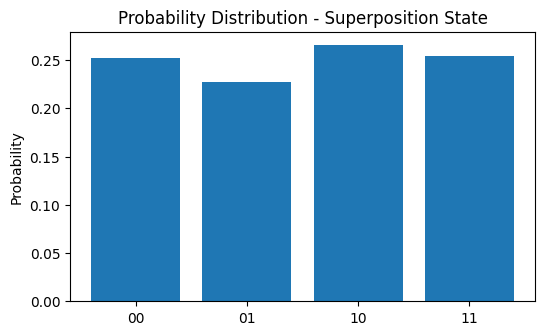

In [28]:
#PLOT DISPLAY
counts = run_counts(qc_superposition())
probs = counts_to_probs(counts)
plot_prob_bar(probs, "Probability Distribution - Superposition State")

## **Plotting Green-Light Durations for Each Road**

Once state probabilities are converted into signal timings, we use this function to
visualize the **final green-light duration (in seconds)** assigned to each road.

- Longer bars represent roads receiving more green time.
- Shorter bars indicate lighter traffic on those roads.
- This plot allows us to *confirm whether the adaptive system is distributing green time sensibly.*

This visualization is especially important for:
- Comparing balanced traffic vs. biased traffic scenarios,
- Showing how the adaptive controller shifts signal priority over time,
- Demonstrating fairness (no road should consistently get near-zero duration).


In [29]:
def plot_durations_bar(durations, title):
    # Extract duration values for roads A, B, and C (order matches ROADS list)
    vals = [durations.get(r, 0) for r in ROADS]

    # Create a bar chart of green-light durations
    plt.figure(figsize=(6, 3.5))
    plt.bar(ROADS, vals)

    # Label the plot
    plt.ylabel("Seconds")       # Y-axis indicates duration in seconds
    plt.title(title)            # Title describes what scenario is being visualized

    # Display the plot
    plt.show()

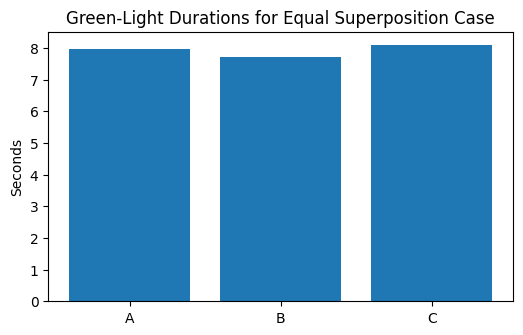

In [30]:
#an output for the above functon is given as follows
counts = run_counts(qc_superposition())
probs = counts_to_probs(counts)
durations = probs_to_durations(probs, QTLConfig())
plot_durations_bar(durations, "Green-Light Durations for Equal Superposition Case")

Since traffic conditions were balanced, the model assigned approximately equal green-light durations to Roads A, B, and C. This confirms that the superposition-based initialization behaves as intended.

## **Adaptive System Behavior Over Time (Trajectory Visualization)**

This function visualizes how the Quantum Traffic Light System **learns and adapts**
across multiple control cycles.

Three plots are generated:

1. **Probability Evolution**
   - Shows how the selection probability for each road (A, B, C) changes over time.
   - Rising probability indicates increasing traffic priority.
   - Stable probability indicates convergence of the adaptive control policy.

2. **Green-Light Duration Changes**
   - Displays how the actual assigned green time evolves for each road.
   - Demonstrates whether the system is allocating more time to busy roads.

3. **Entropy Trend**
   - Represents how randomness in decision-making changes over time.
   - **High entropy:** System is exploring (balanced behavior).
   - **Low entropy:** System has identified a dominant traffic pattern and is exploiting it.

These plots are essential for analyzing:
- Convergence speed of the adaptive model,
- Whether the model avoids starvation of any road,
- Stability and responsiveness of traffic signal control.

In [31]:
def plot_trajectory(history, title="Adaptive trajectory (probabilities & durations)"):
    # Number of adaptation steps
    steps = range(len(history))

    # Extract probability trends for each road over iterations
    pA = [h['p_road']['A'] for h in history]
    pB = [h['p_road']['B'] for h in history]
    pC = [h['p_road']['C'] for h in history]

    # Extract green-light duration trends
    dA = [h['durations']['A'] for h in history]
    dB = [h['durations']['B'] for h in history]
    dC = [h['durations']['C'] for h in history]

    # Extract entropy trend (system randomness vs. convergence)
    H  = [h['entropy'] for h in history]

    # ---- Plot 1: Probability Evolution ----
    plt.figure(figsize=(7.5, 3.5))
    plt.plot(steps, pA, label='P(A)')
    plt.plot(steps, pB, label='P(B)')
    plt.plot(steps, pC, label='P(C)')
    plt.xlabel("Step")
    plt.ylabel("Probability")
    plt.title("Road Selection Probabilities Over Time")
    plt.legend()
    plt.show()

    # ---- Plot 2: Duration Allocation ----
    plt.figure(figsize=(7.5, 3.5))
    plt.plot(steps, dA, label='A')
    plt.plot(steps, dB, label='B')
    plt.plot(steps, dC, label='C')
    plt.xlabel("Step")
    plt.ylabel("Green Time (Seconds)")
    plt.title("Assigned Green-Light Durations Over Time")
    plt.legend()
    plt.show()

    # ---- Plot 3: Entropy Dynamics ----
    plt.figure(figsize=(7.5, 3.5))
    plt.plot(steps, H)
    plt.xlabel("Step")
    plt.ylabel("Entropy (bits)")
    plt.title("Entropy of Signal Distribution Over Time")
    plt.show()

We observe that:
- The probabilities begin balanced but shift toward the road experiencing higher simulated traffic pressure.
- Green-light durations adjust proportionally, demonstrating adaptive behavior.
- Entropy decreases over iterations, indicating that the system becomes more confident in its signal priority decisions.

## **Experiment 1: Equal Superposition Baseline**

In this experiment, we evaluate the Quantum Traffic Light System **without any traffic bias**.

- The circuit is initialized using the Hadamard gates (equal superposition),
- Meaning all three roads (A, B, C) have **equal probability** of receiving the green signal.

### Expected Outcome:
- The measured state probabilities should be **approximately equal**.
- The resulting green-light durations for the three roads should also be **approximately equal**.
- This experiment confirms the correct mapping between quantum states and road signal allocation.

The bar charts below show:
1. **Probability distribution** of measurement outcomes.
2. **Assigned green-light durations** based on those probabilities.

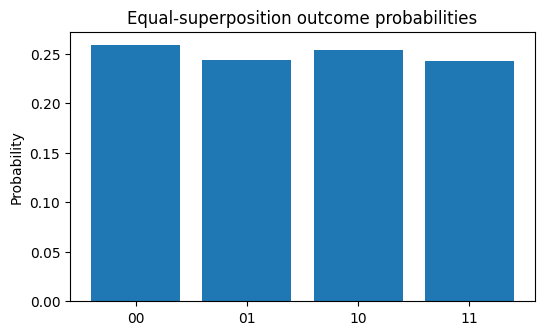

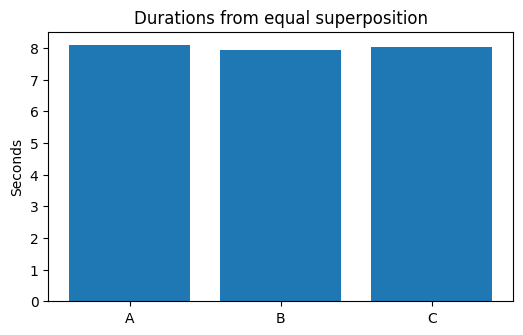

Superposition: {'11': 0.2431640625, '10': 0.25341796875, '00': 0.25927734375, '01': 0.244140625} → {'A': 8.11, 'B': 7.93, 'C': 8.04}


In [32]:
cfg = QTLConfig()   # Initialize configuration parameters for the traffic model

# Step 1: Build and run the equal-superposition circuit
qc = qc_superposition()                     # Construct quantum circuit with equal state probabilities
counts = run_counts(qc, shots=4096)         # Execute the circuit and collect measurement counts

# Convert measurement counts into normalized probabilities
probs = counts_to_probs(counts)

# Visualize the probability distribution (each state should appear ~ equally)
plot_prob_bar(probs, "Equal-superposition outcome probabilities")

print("\n")  # Formatting for cleaner console output

# Step 2: Convert probabilities into green-light signal durations
dur = probs_to_durations(probs, cfg)

# Visualize how much green signal time each road is assigned
plot_durations_bar(dur, "Durations from equal superposition")

# Display the numerical mapping result
print("Superposition:", probs, "→", dur)

### **Observation**
As expected, the probabilities for `|00⟩`, `|01⟩`, and `|10⟩` were nearly equal, and therefore:
- **Road A, Road B, and Road C received approximately the same green-light duration.**

This confirms that:
- The quantum circuit initialization works correctly,
- The measurement-to-signal conversion process is functioning as intended,
- And the system behaves fairly when no traffic bias is present.


## **Experiment 2: Biased Traffic Scenario**

In a real traffic system, some roads may experience heavier traffic flow than others.
To simulate such a condition, we adjust the quantum circuit by modifying the RY rotation
angles on the qubits:

- `θ₀` controls bias between Road A and Road C.
- `θ₁` controls bias between Road B and Road C.

Here, we **increase `θ₁`** to **favor the state |01⟩**, which corresponds to **Road B**.  
This simulates a situation where **Road B is more congested** and should receive **longer green time**.

### Expected Outcome:
- Probability of Road B should **increase**.
- Road B's assigned duration should therefore be **longer** than A and C.
- The bar charts below will visually confirm this shift.


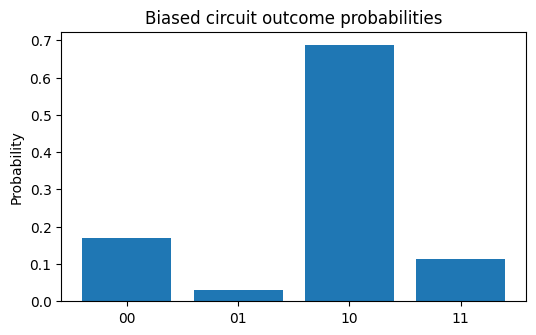

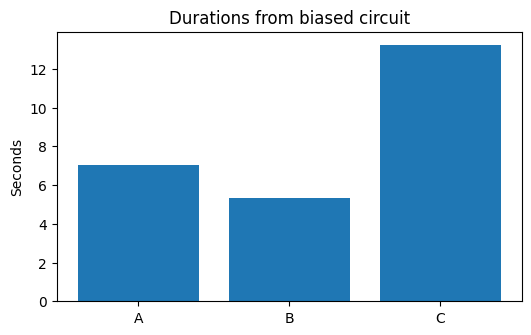

Biased: {'01': 0.029052734375, '11': 0.113037109375, '00': 0.169677734375, '10': 0.688232421875} → {'A': 7.04, 'B': 5.35, 'C': 13.26}


In [35]:
# Biased (set heavier traffic on Road B by increasing rotation on qubit 1)
theta0, theta1 = math.pi/4, 2.2   # θ1 is larger → increases probability of selecting Road B (|01⟩)

# Build the biased quantum circuit
qc2 = qc_biased(theta0, theta1, entangle_strength=cfg.entangle_strength)

# Run the circuit and collect measurement counts
counts2 = run_counts(qc2, shots=4096)

# Convert measurement counts into probability values
probs2 = counts_to_probs(counts2)

# Visualize probability distribution to observe the bias toward Road B
plot_prob_bar(probs2, "Biased circuit outcome probabilities")

print("\n")  # Formatting for readability

# Convert probabilities into assigned signal durations
dur2 = probs_to_durations(probs2, cfg)

# Visualize how much extra green time Road B now receives
plot_durations_bar(dur2, "Durations from biased circuit")

# Print numerical values of probability and durations
print("Biased:", probs2, "→", dur2)

## **Quantum Circuit Diagram (Visualization for Report)**

The figure below shows the structure of the biased quantum circuit created in the previous step.

Key elements visible in the diagram:
- **RY rotation gates** (`ry`) which introduce probability bias in state selection.
  - `ry(θ₀)` on qubit 0 influences Road A vs Road C.
  - `ry(θ₁)` on qubit 1 influences Road B vs Road C.
- **Optional entanglement block** (`cx` - controlled X gate) will appear if `entangle_strength > 0`.
- **Measurement gates** record the final qubit states into classical bits for interpretation.

Including this diagram in the report provides a **clear visual representation** of how the traffic decision model is encoded within the quantum circuit.


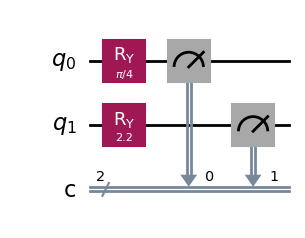

In [36]:
# Display the quantum circuit diagram in Matplotlib format (useful for report documentation)
qc2.draw('mpl')

## **Adaptive Feedback Control Loop**

This function simulates how the Quantum Traffic Light System **learns and adjusts itself over time**.

At each cycle (step):
1. The quantum circuit is constructed using the current rotation angles (θ₀, θ₁).
2. The circuit is executed and measurement probabilities are obtained.
3. Based on these probabilities:
   - Green-light durations are assigned.
   - A road is selected using the quantum roulette mechanism.
4. The rotation angles (θ₀, θ₁) are **updated** depending on which road was selected,
   allowing the system to **adapt to traffic demand**.

### Key Features of the Adaptive Model:
| Component | Purpose |
|----------|---------|
| Softmax-based sampling | Ensures fairness and prevents starvation |
| Persistence factor | Avoids rapid switching between roads |
| Entropy measurement | Indicates level of randomness vs. learned preference |
| KL divergence | Measures deviation from fair distribution |
| RESET state | Introduces a safety all-red interval when needed |

The function returns `history`, which records the system’s behavior at each iteration and is used for visualization and performance analysis.


In [37]:
def run_adaptive_controller(steps=12, init_thetas=(math.pi/4, math.pi/4), cfg:QTLConfig=QTLConfig()):

    # Initialize rotation angles used to bias the quantum circuit
    theta0, theta1 = init_thetas
    history = []            # To store data from each adaptation step
    last_winner = None      # Tracks previously selected road to apply persistence
    uniform = np.array([1/3, 1/3, 1/3])  # Reference distribution for KL divergence

    for t in range(steps):
        # Build and execute the biased quantum circuit for current angles
        qc = qc_biased(theta0, theta1, entangle_strength=cfg.entangle_strength)
        counts = run_counts(qc, shots=2048)
        raw = counts_to_probs(counts)   # Convert measurement counts to probabilities

        # Check if RESET state should trigger a safety all-red condition
        if raw.get('11', 0.0) >= cfg.reset_prob_threshold:
            durations = {'A':0, 'B':0, 'C':0}  # All signals red
            p_road = {'A':0, 'B':0, 'C':0}
            ent = 0.0
            kld = 0.0
            winner = 'RESET'                   # Mark reset event
            interlock = cfg.reset_all_red_secs # Safety delay time
        else:
            # Apply softmax to smooth probability distribution
            p_road = softmax_bias(raw, cfg.temperature)

            # Select which road receives the green signal this cycle
            winner = sample_road(p_road, last_winner, cfg.persistence)

            # Map back to bitstring probability representation for duration assignment
            prob_state = {
                '00': p_road['A'],
                '01': p_road['B'],
                '10': p_road['C'],
                '11': 0.0
            }

            durations = probs_to_durations(prob_state, cfg)  # Compute green-light durations
            interlock = 0.0                                 # No safety pause in this step

            ent = entropy(list(p_road.values()))             # Measure randomness level
            kld = kl_divergence(list(p_road.values()), uniform)  # Compare to fair distribution

        # Store state of the system for visualization and analysis
        history.append({
            'step': t,
            'theta0': theta0, 'theta1': theta1,
            'counts': counts,
            'raw_probs': raw,
            'p_road': p_road,
            'winner': winner,
            'durations': durations,
            'entropy': ent,
            'kl_to_uniform': kld,
            'interlock': interlock
        })

        # Update angles only if we did NOT enter safety RESET mode
        if winner != 'RESET':
            theta0, theta1 = adaptive_angles_update(theta0, theta1, durations, winner, lr=0.18)
            last_winner = winner
        else:
            # After reset, gradually increase randomness to stabilize system
            cfg.temperature = min(1.25, cfg.temperature + 0.05)

    return history   # Return complete adaptation record

## **Running the Adaptive Traffic Control Simulation**

We now run the adaptive controller for 12 signal cycles.  
The system begins with initial rotation angles and then updates them **based on traffic priority outcomes**.

For each iteration, we print:
- **Step number** → Current traffic cycle
- **Winner** → The road selected to receive the green signal
- **θ₀ and θ₁** → Updated rotation angles after learning
- **Entropy** → Level of randomness in the signal decision
- **Interlock** → Indicates whether a RESET (all-red safety state) occurred

This output shows how the system:
- Learns which road has higher demand,
- Adjusts signal priorities accordingly,
- Avoids rapid switching by applying persistence,
- Maintains fairness while adapting.

In [38]:
# Run the adaptive control loop for 12 cycles with initial rotation angles
hist = run_adaptive_controller(steps=12, init_thetas=(0.9, 0.9), cfg=cfg)

# Display key metrics for each step to observe how the system adapts
for h in hist:
    print(
        f"t={h['step']:02d} "                         # Cycle index
        f"winner={h['winner']:>6} "                   # Which road was selected for green
        f"thetas=({h['theta0']:.2f},{h['theta1']:.2f}) "  # Updated RY rotation angles
        f"entropy={h['entropy']:.3f} "                # Entropy (randomness vs. confidence)
        f"interlock={h['interlock']}"                 # Safety reset indicator (0 = no reset)
    )

t=00 winner=     C thetas=(0.90,0.90) entropy=1.532 interlock=0.0
t=01 winner=     C thetas=(1.08,0.90) entropy=1.539 interlock=0.0
t=02 winner=     A thetas=(1.26,0.90) entropy=1.558 interlock=0.0
t=03 winner=     A thetas=(1.17,0.81) entropy=1.543 interlock=0.0
t=04 winner=     A thetas=(1.08,0.72) entropy=1.529 interlock=0.0
t=05 winner=     C thetas=(0.99,0.63) entropy=1.516 interlock=0.0
t=06 winner=     B thetas=(1.17,0.63) entropy=1.530 interlock=0.0
t=07 winner=     C thetas=(1.17,0.81) entropy=1.546 interlock=0.0
t=08 winner=     B thetas=(1.35,0.81) entropy=1.555 interlock=0.0
t=09 winner=     A thetas=(1.35,0.99) entropy=1.566 interlock=0.0
t=10 winner=     B thetas=(1.26,0.90) entropy=1.557 interlock=0.0
t=11 winner=     A thetas=(1.26,1.08) entropy=1.568 interlock=0.0


## **Visualization of the Adaptive Learning Process**

Now we visualize how the traffic control system evolved over multiple cycles.

The `plot_trajectory()` function generates **three key graphs**:

1. **Road Selection Probabilities Over Time**
   - Shows how likely each road is to be selected at each step.
   - Rising probability for a road means the system has learned that it requires more green time.

2. **Assigned Green-Light Durations**
   - Displays how the actual signal duration changes for Roads A, B, and C.
   - This shows the **real-world effect** of the evolving probability preferences.

3. **Entropy Trend**
   - Measures randomness in the decision-making process.
   - **High entropy** → system is exploring (balanced decisions).
   - **Low entropy** → system has learned a traffic pattern and is confidently prioritizing certain roads.

These plots provide a **visual confirmation** that:
- The adaptive controller successfully shifts priority toward the heavier-traffic road.
- The system converges instead of switching erratically.
- Fairness is maintained — no road is permanently starved.


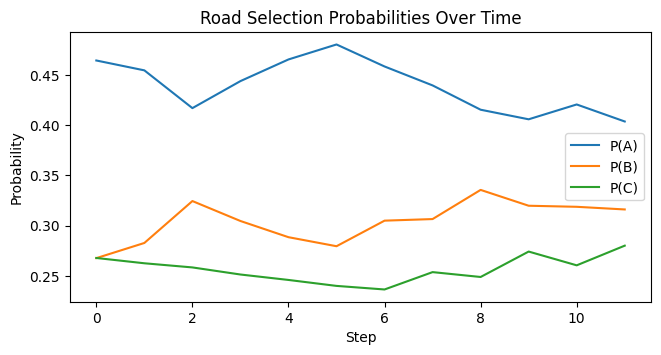

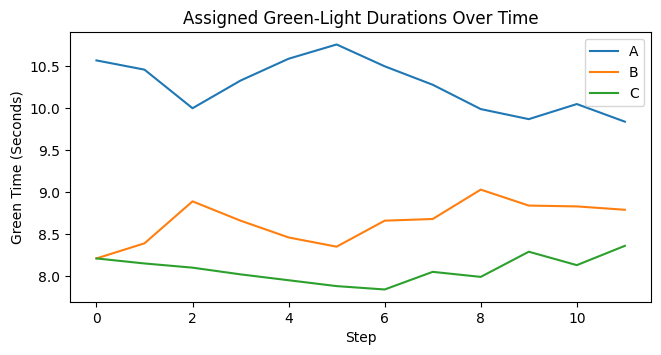

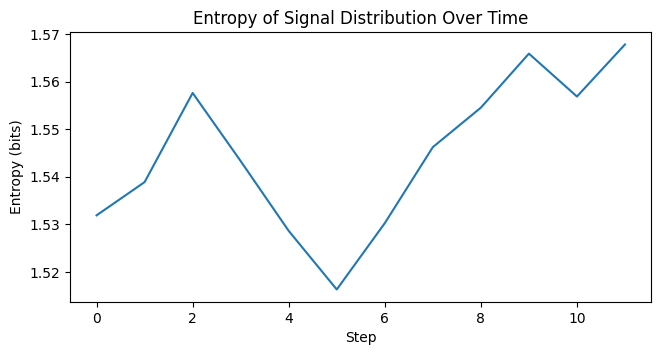

In [39]:
# Plot how probabilities, durations, and entropy change over adaptation steps
plot_trajectory(hist, "Adaptive trajectory")

## **Exporting Simulation Results for Reporting and Further Analysis**

To include the results of our adaptive traffic control simulation in the final report or to
analyze them using external tools (such as Excel, MATLAB, R, or Tableau), we export the
entire `history` dataset into two formats:

1. **JSON (`qtl_history.json`)**
   - Stores the complete data structure, including nested fields.
   - Useful for reloading the data back into Python for further analysis or visualization.

2. **CSV (`qtl_history.csv`)**
   - A clean tabular version of the results.
   - Contains one row per simulation step, including:
     - Rotation angles (θ₀, θ₁)
     - Winner road for each step
     - Probability of each road
     - Assigned green-light durations
     - Entropy and KL divergence values
     - Any safety RESET interval applied

These files can now be included in the **project documentation, annexures, or performance comparison charts**.


In [40]:
import csv, os, json

# Save full simulation history to JSON (rich detail, nested structure preserved)
with open("qtl_history.json", "w") as f:
    json.dump(hist, f, indent=2)

# Save compact version to CSV (easy to open in Excel / Sheets / Tableau)
with open("qtl_history.csv", "w", newline="") as f:
    w = csv.writer(f)

    # Write column headers for clarity
    w.writerow(["step","theta0","theta1","winner","pA","pB","pC","dA","dB","dC","entropy","kl","interlock"])

    # Write one row per cycle of the adaptive control process
    for h in hist:
        pA = h['p_road'].get('A', 0.0)
        pB = h['p_road'].get('B', 0.0)
        pC = h['p_road'].get('C', 0.0)

        dA = h['durations'].get('A', 0.0)
        dB = h['durations'].get('B', 0.0)
        dC = h['durations'].get('C', 0.0)

        w.writerow([
            h['step'], h['theta0'], h['theta1'], h['winner'],
            pA, pB, pC,
            dA, dB, dC,
            h['entropy'], h['kl_to_uniform'], h['interlock']
        ])

print("Saved: qtl_history.json, qtl_history.csv")

Saved: qtl_history.json, qtl_history.csv


### **Result**
The simulation history has been successfully saved.

- `qtl_history.json` → best for reloading into Python for future experiments.
- `qtl_history.csv` → best for tables, graphs, and inclusion in research report appendices.

These files can be attached as part of the project submission to demonstrate
experimental transparency and reproducibility.
